In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('ggplot')
import seaborn as sns
import statistics

In [2]:
results = pd.read_csv("test_results/operator_fusion_test_results.csv") 
test_name = "operator_fusion"

results = results.rename(columns={"Average": "Mean"})

In [3]:
results.head()

,Data Type,Scaling Factor,Query Name,Query Number,Mean,Correct,Runs
0,SQL,1,SQL,Query 1,5.19,True,"[5.241247892379761, 5.076302528381348, 5.24921..."
1,Pandas,1,Pandas,Query 1,2.74,True,"[2.8451809883117676, 2.6840970516204834, 2.694..."
2,Pandas,1,Pandas Group Fusion,Query 1,2.76,True,"[2.848106622695923, 2.719176769256592, 2.71594..."
3,Pandas,1,Pandas Merge Fusion,Query 1,2.76,True,"[2.8542792797088623, 2.7172560691833496, 2.699..."
4,Pandas,1,Pandas Both Fusion,Query 1,2.79,True,"[2.8534576892852783, 2.7795658111572266, 2.726..."


In [4]:
# Sort Query Name column to in-order
def extract_number(name):
    return int(name.split(" ")[1])

results['Query Number'] = results.apply(lambda row : extract_number(row['Query Number']), axis = 1)
results = results.sort_values(['Query Number'])

# Fix the runs column
def fix_runs(runs):
    new_runs = list(str(str(runs)[1:-1]).split(","))
    for i in range(0, len(new_runs)):
        new_runs[i] = float(new_runs[i].strip())
    return new_runs

results['Runs'] = results.apply(lambda row : fix_runs(row['Runs']), axis = 1)

results['Median'] = results.apply(lambda row: statistics.median(sorted(row['Runs'])), axis = 1)

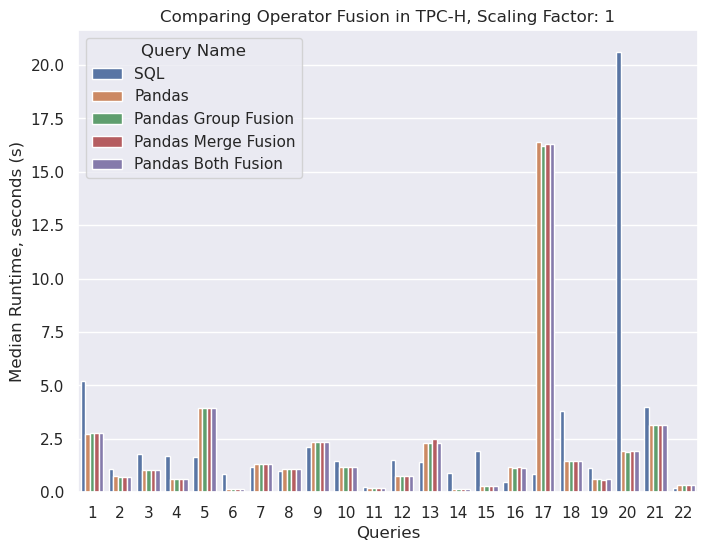

In [6]:
# plot with seaborn barplot
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(data=results, x='Query Number', y='Mean', hue='Query Name')
#ax.set_yscale("log")
ax.set(xlabel='Queries', ylabel='Median Runtime, seconds (s)')
plt.title("Comparing Operator Fusion in TPC-H, Scaling Factor: 1")
#set parameters for tick labels
plt.tick_params(axis='x', which='major', labelsize=11)
#plt.tick_params(axis='y', which='major', labelsize=10)
plt.savefig("analysis_results/" + str(test_name) + "_compare_queries.svg")
plt.show()

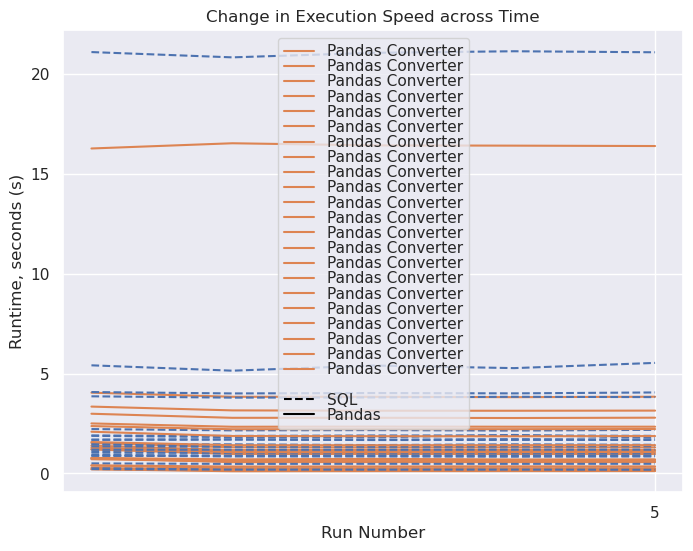

In [8]:
# Make graph of change in runtimes
# Y: Run time, X: Run Number
# Line: Query Number
prev_colors = {}

fig, ax = plt.subplots()

for index, row in results.iterrows():
    if row["Data Type"] == "SQL":
        line_style = 'dashed'
        legend_info = None
    else:
        line_style = 'solid'
        legend_info = row["Query Name"]
    
    # Choose line color
    if prev_colors.get(row["Query Name"], None) == None:
        # Not in dataframe
        line = ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style)
        prev_colors[row["Query Name"]] = line[0].get_color()
    else:
        color_line = prev_colors[row["Query Name"]]
        ax.plot(list(range(1, len(row["Runs"])+1)), row["Runs"], label=legend_info, linestyle=line_style, color=color_line)

# Add extra info to legend
ax.plot([], [], " ", label=" "*5,)
ax.plot([], [], label="SQL", color="black", linestyle="dashed")
ax.plot([], [], label="Pandas", color="black", linestyle="solid")

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.title('Change in Execution Speed across Time')
plt.xlabel('Run Number')
plt.ylabel('Runtime, seconds (s)')
ax.legend(labelspacing=0.01)
plt.savefig("analysis_results/" + str(test_name) + "_compare_queries_exec_time.pdf")
plt.show()